# Linear Regression Implementation from Scratch



**we will implement the entire method from scratch,**
including
- (i) the model;
- (ii) the loss function;
- (iii) a minibatch stochastic gradient descent optimizer;
- (iv) the training function

that stitches all of these pieces together.
Finally, we will run our synthetic data generator
from
and apply our model
on the resulting dataset.



In [8]:
# Import necessary library
import torch
from torch import nn
import matplotlib.pyplot as plt



## Defining the Model



In the following we initialize weights by drawing
random numbers from a normal distribution with mean 0
and a standard deviation of 0.01.
The magic number 0.01 often works well in practice.


In [9]:
class LinearRegressionScratch(nn.Module):
  def __init__(self, input_dim, sigma=0.01):
      super().__init__()
      self.w = torch.normal(0, sigma, (input_dim, 1), requires_grad=True)

      self.b = torch.zeros(1, requires_grad=True)


###Given
for our linear model we simply take the matrix--vector product
of the
- input features $\mathbf{X}\in \mathbb{R}^{B\times d}$
- the model weights $\mathbf{w}\in \mathbb{R}^{d\times 1}$,
- add the offset $b\in \mathbb{R}^{1}$ to each example.

### Calculation
1. The product $\mathbf{Xw}\in \mathbb{R}^{B\times 1}$ is a vector and $b$ is a scalar.

2. Because of the **broadcasting** mechanism,
when we add a vector and a scalar,
the scalar is added to each component of the vector.


3. The function `forward` reutrn a vector of dimension $ \mathbb{R}^{B\times 1}$


In [10]:
def sigmoid(x):
  return 1/(1+ torch.exp(-x))

def forward(self, X):

    z= torch.matmul(X, self.w) + self.b
    z = sigmoid(z)
    return z

LinearRegressionScratch.forward=forward

## Defining the Loss Function

Since updating our model requires taking the gradient of our loss function, we should define the loss function first. Here we use the **negative log-likelihood (NLL)** loss, which measures how much probability the model assigns to the correct label. In the implementation, we reshape the true labels `y` to match the shape expected by the predictions (or logits) `y_hat`. The loss is computed per example and then **averaged over all examples in the minibatch**.



In [11]:
def loss(self, y_hat, y, eps=1e-12):

    # 0<y_hat <1: probabilities in (0,1),
    # y: {0,1}
    # y_hat = torch.clamp(y_hat, eps, 1 - eps)
    y_hat =torch.clamp(y_hat, eps, 1-eps)
    mini_batch_loss=-(y * torch.log(y_hat) + (1-y)* torch.log(1-y_hat))
    return mini_batch_loss.mean()

LinearRegressionScratch.loss=loss

## Defining the Optimization Algorithm


The following code applies the update,
given a set of parameters, a learning rate `lr`.



We define our `SGD` class,

- We update the parameters in the `step` method.
- The `zero_grad` method sets all gradients to 0,
which must be run before a backpropagation step.


In [21]:
class SGD:
    """Minibatch stochastic gradient descent."""
    def __init__(self, params, lr):
        self.params = params
        self.lr=lr

    @torch.no_grad()
    def step(self):
      for param in self.params:
          param  -= self.lr * param.grad


    def zero_grad(self):
      for param in self.params:
        if param.grad is not None:
          param.grad.zero_()

We next define the `configure_optimizers` method, which returns an instance of the `SGD` class.


## Training step




- In each *epoch*, we iterate through the entire training dataset, passing once through every example


  In each *iteration*,
  -  we grab a minibatch of training examples,
  - compute its loss through the model's `training_step` method.
  - we compute the gradients with respect to each parameter.
  - we will call the optimization algorithm to update the model parameters.

### parameter update step
we will execute the following loop:

* Initialize parameters $(\mathbf{w}, b)$
* Repeat until done
* Compute gradient $\mathbf{g} \leftarrow \nabla_{(\mathbf{w},b)} \frac{1}{|\mathrm{B}|} \sum_{i \in \mathrm{B}} \ell(\mathbf{x}^{(i)}, y^{(i)}, \mathbf{w}, b)$
* Update parameters $(\mathbf{w}, b) \leftarrow (\mathbf{w}, b) - \eta \mathbf{g}$




We are almost ready to train the model,
but first we need some training data.
Here we use the `SyntheticRegressionData` class
and pass in some ground truth parameters.


In [22]:
from torch.utils.data import Dataset, DataLoader

# ---------- dataset ----------
class SyntheticDataGeneration(Dataset):
    def __init__(self, w, b, num_examples=1000, noise_std=0.01):
        self.X = torch.randn(num_examples, len(w))
        noise = torch.randn(num_examples) * noise_std
        self.y = sigmoid(self.X @ w)+ b + noise
        self.y = (self.y > 0.5).float()  # (N,1)
        self.y = self.y.reshape(-1, 1)  # shape (N,1)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]




Hyper-parameters:
  - learning rate `lr`
  - the number of epochs  `max_epochs`.


In [33]:
max_epochs=100
batch_size=10
num_inputs=5

In [34]:
dataset = SyntheticDataGeneration(w=torch.rand(num_inputs), b=torch.randn(1), num_examples=100)
train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [35]:

model = LinearRegressionScratch(num_inputs)
optim = SGD([model.w, model.b], lr=0.01)

In [36]:
loss_history = []

model.train()
max_epochs=10
for ei in range(max_epochs):
  for train_batch_idx, (X,y) in enumerate(train_dataloader):
    y_hat =model(X)
    loss=model.loss(y_hat, y)
    optim.zero_grad()
    loss.backward()
    optim.step()
    print(f"epoch: {ei}, index: {train_batch_idx}, loss = {loss.item():.6f}")

    loss_history.append(loss.item())



epoch: 0, index: 0, loss = 0.695978
epoch: 0, index: 1, loss = 0.691479
epoch: 0, index: 2, loss = 0.692777
epoch: 0, index: 3, loss = 0.685833
epoch: 0, index: 4, loss = 0.684096
epoch: 0, index: 5, loss = 0.683293
epoch: 0, index: 6, loss = 0.678898
epoch: 0, index: 7, loss = 0.681921
epoch: 0, index: 8, loss = 0.675285
epoch: 0, index: 9, loss = 0.670754
epoch: 1, index: 0, loss = 0.673087
epoch: 1, index: 1, loss = 0.664306
epoch: 1, index: 2, loss = 0.678667
epoch: 1, index: 3, loss = 0.665892
epoch: 1, index: 4, loss = 0.658693
epoch: 1, index: 5, loss = 0.655918
epoch: 1, index: 6, loss = 0.653773
epoch: 1, index: 7, loss = 0.671738
epoch: 1, index: 8, loss = 0.650219
epoch: 1, index: 9, loss = 0.654389
epoch: 2, index: 0, loss = 0.657579
epoch: 2, index: 1, loss = 0.645955
epoch: 2, index: 2, loss = 0.641900
epoch: 2, index: 3, loss = 0.641570
epoch: 2, index: 4, loss = 0.647731
epoch: 2, index: 5, loss = 0.641767
epoch: 2, index: 6, loss = 0.649455
epoch: 2, index: 7, loss = 0

Because we synthesized the dataset ourselves,
we know precisely what the true parameters are.
Thus, we can [**evaluate our success in training
by comparing the true parameters
with those that we learned**] through our training loop.
Indeed they turn out to be very close to each other.


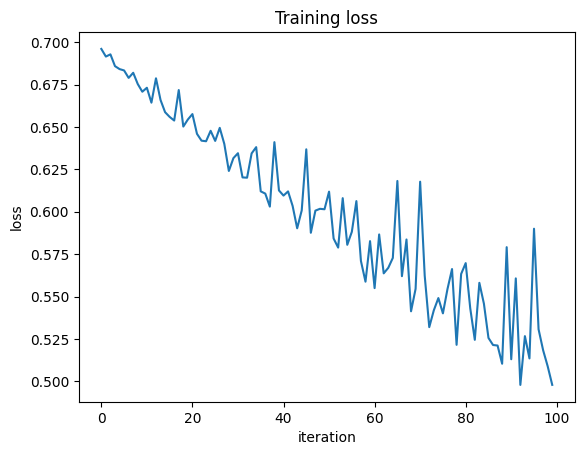

In [37]:

# Plot
plt.figure()
steps = range(len(loss_history))
plt.plot(steps, loss_history)
plt.xlabel("iteration")
plt.ylabel("loss")
plt.title("Training loss")
plt.show()